In [2]:
import pandas as pd 
import numpy as np
import datetime as dt
import seaborn as sns

data = './data/water.csv'
water = pd.read_csv(data, index_col=0)
  
water.head()

,lat_deg,lon_deg,report_date,status_id,water_source,water_tech,facility_type,country_name,install_year,installer,pay,status
row_id,,,,,,,,,,,,
3957,8.073136,38.617037,04/06/2017,y,NaN,NaN,NaN,Ethiopia,NaN,Private-CRS,NaN,NaN
33512,7.373784,40.503824,08/04/2020,y,Protected Spring,NaN,Improved,Ethiopia,2019.0,WaterAid,NaN,NaN
35125,0.773458,34.929509,03/18/2015,y,Protected Shallow Well,NaN,Improved,Kenya,NaN,NaN,NaN,NaN
37760,0.780576,34.963640,03/18/2015,y,Borehole,NaN,Improved,Kenya,NaN,NaN,NaN,NaN
38118,0.779266,34.971120,03/18/2015,y,Protected Shallow Well,NaN,Improved,Kenya,NaN,NaN,NaN,NaN


In [3]:
water.rename(
  {'lat_deg':'lat',
  'lon_deg':'lon',
  'country_name':'country'}, axis=1, inplace=True)

In [4]:
uniques = {col:list(water[col].unique()) for col in water.columns[4:]}

print(uniques['water_tech']) # Includes both method and development company after '-'
print(uniques['country']) # Includes nan values and non-African countries: Peru, Dominican Republic, Timor-Leste

[nan, 'Hand Pump - India Mark', 'Mechanized Pump', 'Tapstand', 'Hand Pump', 'Kiosk', 'Hand Pump - Vergnet', 'Hand Pump - Nira', 'Hand Pump - Afridev', 'Rope and Bucket', 'Mechanized Pump - Solar', 'Hand Pump - Canzee', 'Hydram', 'Hand Pump - Kardia', 'Hand Pump - Consallen', 'Hand Pump - Inkar', 'Hand Pump - SWN 80', 'Hand Pump - Indus', 'Hand Pump - PB Mark II', 'Mechanized Pump - Diesel']
['Ethiopia', 'Kenya', 'Central African Republic', 'Uganda', 'Niger', 'Mozambique', 'Liberia', 'Peru', 'Swaziland', 'Sierra Leone', 'Zambia', 'Nigeria', 'Ghana', 'Burkina Faso', 'Zimbabwe', 'Madagascar', 'Tanzania', 'South Sudan', 'Mali', 'Rwanda', 'South Africa', nan, 'Dominican Republic', 'Burundi', 'Gambia', 'Congo - Kinshasa', 'Angola', 'Algeria', 'Namibia', 'Sudan', 'Congo - Brazzaville', 'Chad', 'Mauritania', 'Timor-Leste', 'Egypt']


In [5]:
water['report_date'] = pd.to_datetime(water['report_date'])
water[['water_tech','brand']] = water['water_tech'].str.split('-',expand=True)
water = water[~water['country'].isin(['Peru', 'Dominican Republic', 'Timor-Leste'])]
water = water[~water['country'].isna()]

<AxesSubplot: xlabel='install_year', ylabel='Count'>

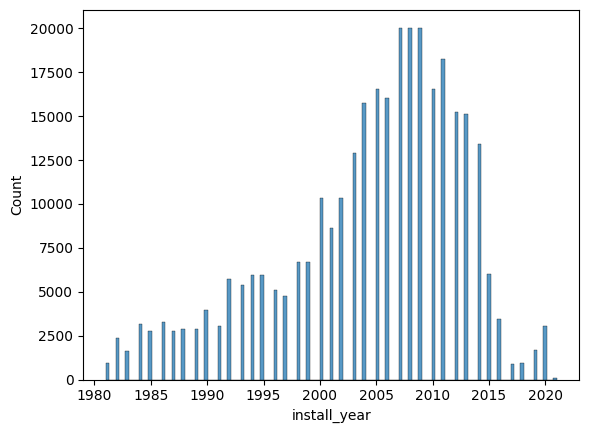

In [6]:
# sns.histplot(water['install_year']) # Includes years after 2021
water['install_year'] = np.where(water['install_year'] > 2021, np.nan, water['install_year'])

df = water[water['install_year'] > 1980]
sns.histplot(df['install_year'])

#### Creating a Map


In [75]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

def get_points(df):
  return [Point(xy) for xy in zip(df['lon'], df['lat'])]

water_gdf = gpd.GeoDataFrame(water, geometry=get_points(water))

world = gpd.read_file(
  gpd.datasets.get_path('naturalearth_lowres')
)
africa = world.query('continent == "Africa"')

<AxesSubplot: >

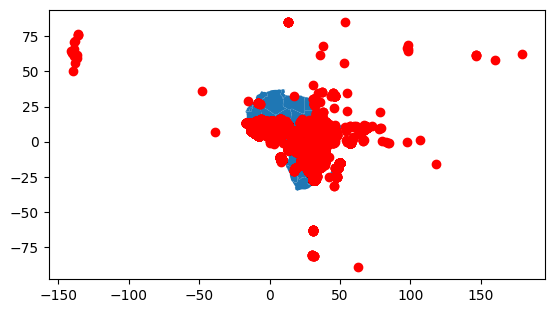

In [8]:
water_gdf.plot(ax=africa.plot(), marker = 'o', color='red')

A lot of erroneous points lying outside the actual continent. 

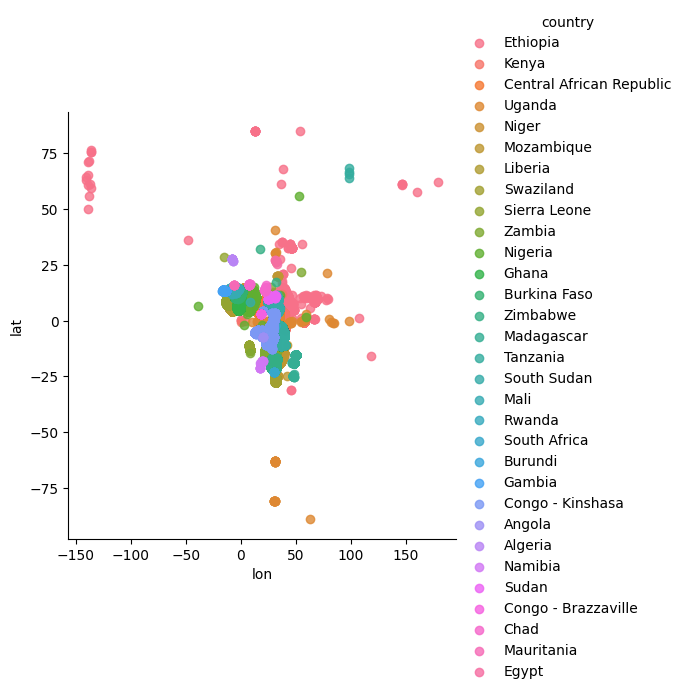

In [9]:
sns.lmplot(data=water_gdf, x='lon', y='lat', fit_reg=False, hue='country')

Swaziland clearly has a significant amount of erroneous points (its mean latitude is below South Africa's!) 

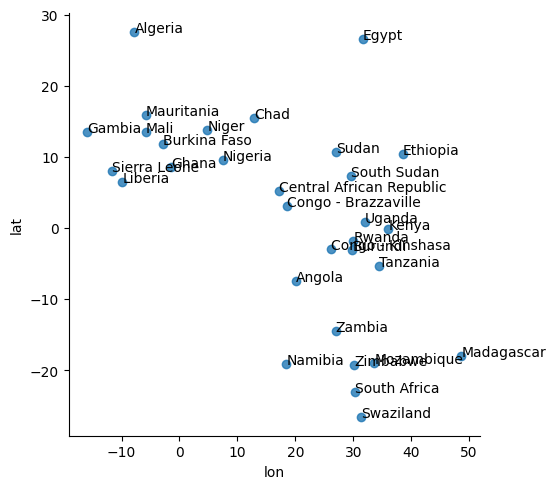

In [67]:
import matplotlib.pyplot as plt

ax = sns.lmplot(x='lon', 
           y='lat', 
           data=df, 
           fit_reg=False)  

# Set x-axis label
plt.xlabel('lon')
# Set y-axis label
plt.ylabel('lat')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(df.lon, df.lat, df.country, plt.gca()) 

Hard to tell which countries the outlier points belong to based on subtle differences in hues. Plotting the country name next to each point for more than 400k points is also not going to make things clear! 

We can, however, calculate the mean of all the coordinates located within a country and then exclude points which lie outside a certain distance of that mean. 

(Alternatively, we could find polygon geometries for each country and filter out points associated with each country that lie outside its respective polyon. We'll try this out if our first idea fails).

In [76]:
df = water_gdf[['country', 'lat', 'lon']].groupby('country').mean()
df.reset_index(inplace=True)
centers = gpd.GeoDataFrame(df['country'], geometry=get_points(df)).set_index('country')
centers.rename({'geometry':'center'}, axis=1, inplace=True)
centers # not true country centers, as water access points in each country are not randomly distributed

,center
country,
Algeria,POINT (-7.77389 27.51296)
Angola,POINT (20.05520 -7.40231)
Burkina Faso,POINT (-2.83791 11.82479)
Burundi,POINT (29.83500 -3.15500)
Central African Republic,POINT (17.16059 5.14862)
Chad,POINT (12.94218 15.49871)
Congo - Brazzaville,POINT (18.53895 3.09209)
Congo - Kinshasa,POINT (26.20132 -2.98834)
Egypt,POINT (31.67089 26.60136)


In [77]:
water_gdf = water_gdf.merge(centers, how='left', left_on='country', right_index=True)
water_gdf['distance'] = gpd.GeoSeries.distance(water_gdf['geometry'], water_gdf['center'])

In [79]:
distance_describe = water_gdf[['country', 'distance']].groupby('country').describe()['distance']
distance_describe.sort_values('max', ascending=False)

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Ethiopia,25917.0,2.764525,5.619654e+00,0.198204,1.294885,1.737541,3.148392,187.515887
Tanzania,24923.0,3.375251,1.884711e+00,0.038067,2.240180,3.546762,4.544180,97.373368
Uganda,119671.0,1.822817,1.439295e+00,0.010354,1.254507,1.895369,2.341333,94.866810
Nigeria,83703.0,3.168881,1.099852e+00,0.063072,2.589574,3.280464,3.880424,65.069518
Zimbabwe,23695.0,1.705646,7.973180e-01,0.032955,1.228794,1.655083,2.231147,53.076917
Swaziland,23913.0,0.428347,3.934213e-01,0.000771,0.259050,0.445597,0.591645,52.889160
Zambia,9093.0,3.097668,1.777564e+00,0.076451,1.747273,2.537338,4.240253,45.989158
Mozambique,2478.0,0.871822,2.473624e+00,0.020342,0.236870,0.479536,0.726601,39.050992
Kenya,12153.0,2.487605,3.698711e+00,0.147916,1.445727,1.779886,1.934991,35.503826
